In [1]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def myround(x, prec=2, base=.5):
  return round(base * round(float(x)/base),prec)

In [3]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

In [4]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("WFIRST")]
model_mags = 0.
model = 'AB'
pbnames += ['sdss,g', 'sdss,r', 'sdss,i', 'sdss,z']
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

/Users/gnarayan/work/source_synphot/source_synphot/passband.py:326: RuntimeWarning: Passband W149 not loaded
  warnings.warn(message, RuntimeWarning)


In [5]:
print(pbnames)

odict_keys(['R606', 'Z087', 'Y106', 'J129', 'H158', 'F184', 'sdss,g', 'sdss,r', 'sdss,i', 'sdss,z'])


In [6]:
color1 = 'sdss,g_sdss,r'
color2 = 'sdss,r_sdss,i'
col1 = []
col2 = []
# construct color-color vectors
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    c1, c2 = color1.split('_')
    pb1, zp1 = pbs[c1]
    pb2, zp2 = pbs[c2]
    c3, c4 = color2.split('_')
    pb3, zp3 = pbs[c3]
    pb4, zp4 = pbs[c4]
    thiscol1 = source_synphot.passband.syncolor(model, pb1, pb2, zp1, zp2)
    thiscol2 = source_synphot.passband.syncolor(model, pb3, pb4, zp3, zp4)
    col1.append(thiscol1)
    col2.append(thiscol2)
col1 = array(col1)
col2 = array(col2)
# select only useful objects
good = ~isnan(col1)* ~isnan(col2)
good = array(good)


/Users/gnarayan/work/source_synphot/source_synphot/passband.py:116: RuntimeWarning: divide by zero encountered in log10
  m1 = -2.5*np.log10(flux1) + zp1
/Users/gnarayan/work/source_synphot/source_synphot/passband.py:118: RuntimeWarning: divide by zero encountered in log10
  m2 = -2.5*np.log10(flux2) + zp2
/Users/gnarayan/work/source_synphot/source_synphot/passband.py:119: RuntimeWarning: invalid value encountered in double_scalars
  return m1-m2


<IPython.core.display.Javascript object>


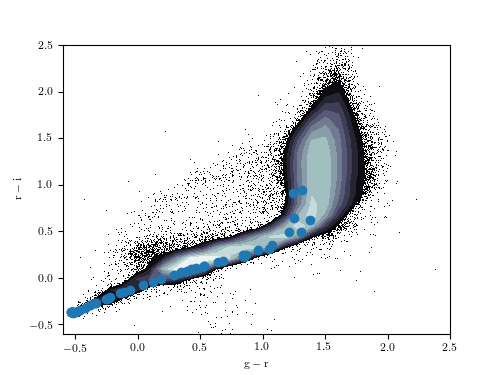

In [7]:

from astroML.plotting import scatter_contour
from astroML.datasets import fetch_sdss_S82standards
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

data = fetch_sdss_S82standards()

g = data['mmu_g']
r = data['mmu_r']
i = data['mmu_i']

fig, ax = plt.subplots(figsize=(5, 3.75))
scatter_contour(g - r, r - i, threshold=200, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm r - i}$')

ax.set_xlim(-0.6, 2.5)
ax.set_ylim(-0.6, 2.5)
plot(col1[good], col2[good], marker='o', linestyle='None')
